# Análisis de errores en GRAVITY (6 meses)

Este notebook analiza las observaciones con `ERROR = True` del instrumento
**GRAVITY**, utilizando los parlogs correspondientes a una ventana de 6 meses.
Se estudian los `TPL_ID` con más errores, los parámetros numéricos asociados y
se aplica clustering para identificar diferentes tipos de error internos.


In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import cluster_todos_en_conjunto,plot_clusters_por_cluster_y_origen

plt.style.use('default')
plt.rcParams['font.size'] = 10

## Carga del dataset y filtrado de observaciones con error

Se cargan los parlogs mediante `ParlogsObservations`. A partir de:

- `df_meta`: información a nivel de observación  
- `df_traces`: información a nivel de traza  

se filtran únicamente las observaciones donde `ERROR = True`.  
Estas conforman la base completa del análisis de GRAVITY.


In [2]:
INSTRUMENT='GRAVITY'
RANGE='6m'

In [3]:
config = {
    'period': RANGE,
    'system': INSTRUMENT,
    'source': "Instrument",
    'dataset_dir': "../../data"
}
logs = ParlogsObservations(**config)
#logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

In [ ]:
df_meta = logs.meta
df_meta = df_meta[ df_meta['ERROR'] == True]
df_traces = logs.traces()
df_traces = df_traces[df_traces['trace_id'].isin(df_meta.index)]
TPL_IDs = logs.meta['TPL_ID'].value_counts()

## TPL_ID con mayor número de errores

Se cuenta cuántas observaciones con error están asociadas a cada `TPL_ID`
y se seleccionan únicamente los casos con **25 o más errores**.
Esto permite enfocar el análisis en plantillas representativas y con suficiente
cantidad de datos para realizar clustering.


In [5]:
tpl_counts_err = df_meta['TPL_ID'].value_counts()
print("TPL_ID con errores más frecuentes:")
display(tpl_counts_err.head(10))

TPL_ID con errores más frecuentes:


TPL_ID
GRAVITY_single_acq               271
GRAVITY_gen_cal_init              55
GRAVITY_dual_acq                  52
GRAVITY_gen_tec_checkMetZero      45
GRAVITY_single_obs_exp            31
GRAVITY_dual_obs_swap             31
GRAVITY_dual_acq_dither           29
Dual                              22
Fringe                            16
GRAVITY_single_obs_calibrator     16
Name: count, dtype: int64

In [6]:
MIN_ERR_POR_TPL = 25

tpl_ids_validos = tpl_counts_err[tpl_counts_err >= MIN_ERR_POR_TPL].index.tolist()
print("TPL_ID usados en TODAS las figuras:", tpl_ids_validos)


TPL_ID usados en TODAS las figuras: ['GRAVITY_single_acq', 'GRAVITY_gen_cal_init', 'GRAVITY_dual_acq', 'GRAVITY_gen_tec_checkMetZero', 'GRAVITY_single_obs_exp', 'GRAVITY_dual_obs_swap', 'GRAVITY_dual_acq_dither']


## Extracción de parámetros numéricos

Para cada `TPL_ID` seleccionado se extraen los parámetros numéricos de sus
trazas. El proceso incluye:

- eliminar columnas con más del 50% de valores faltantes,
- eliminar filas con demasiados `NaN`,
- descartar parámetros constantes.

El resultado es un dataframe limpio por `TPL_ID`, con los parámetros
numéricos necesarios para análisis estadístico y clustering.


In [7]:
tpl_params_dict_err = {}
threshold_nan = 0.5

for tpl_id in df_meta['TPL_ID'].unique():
    # Solo con error
    params_df_err = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    if params_df_err is None:
        params_df_err = pd.DataFrame()
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]
    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err

print(f"Se extrajeron parámetros numéricos para {len(tpl_params_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros numéricos para 22 TPL_ID con errores.


## Histogramas de parámetros numéricos

Se visualizan los parámetros numéricos mediante histogramas para detectar:

- parámetros que cambian su comportamiento al ocurrir un error,
- diferencias en dispersión,
- tendencias anómalas,
- valores extremos o atípicos.

Cuando un parámetro presenta una concentración muy fuerte en pocos valores,
se utiliza una escala logarítmica en el eje Y para mejorar la legibilidad.


Creando gráficos tipo 'histograma' para 20 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.GS.FWHM', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.DIT', 'DET2.NDIT.SKY', 'INS.STSOFFANG', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EQUINOX', 'TEL.TARG.RADVEL', 'TEL.TARG.WLENGTH']
Figura guardada en: figuras/GRAVITY_single_acq_hist.png


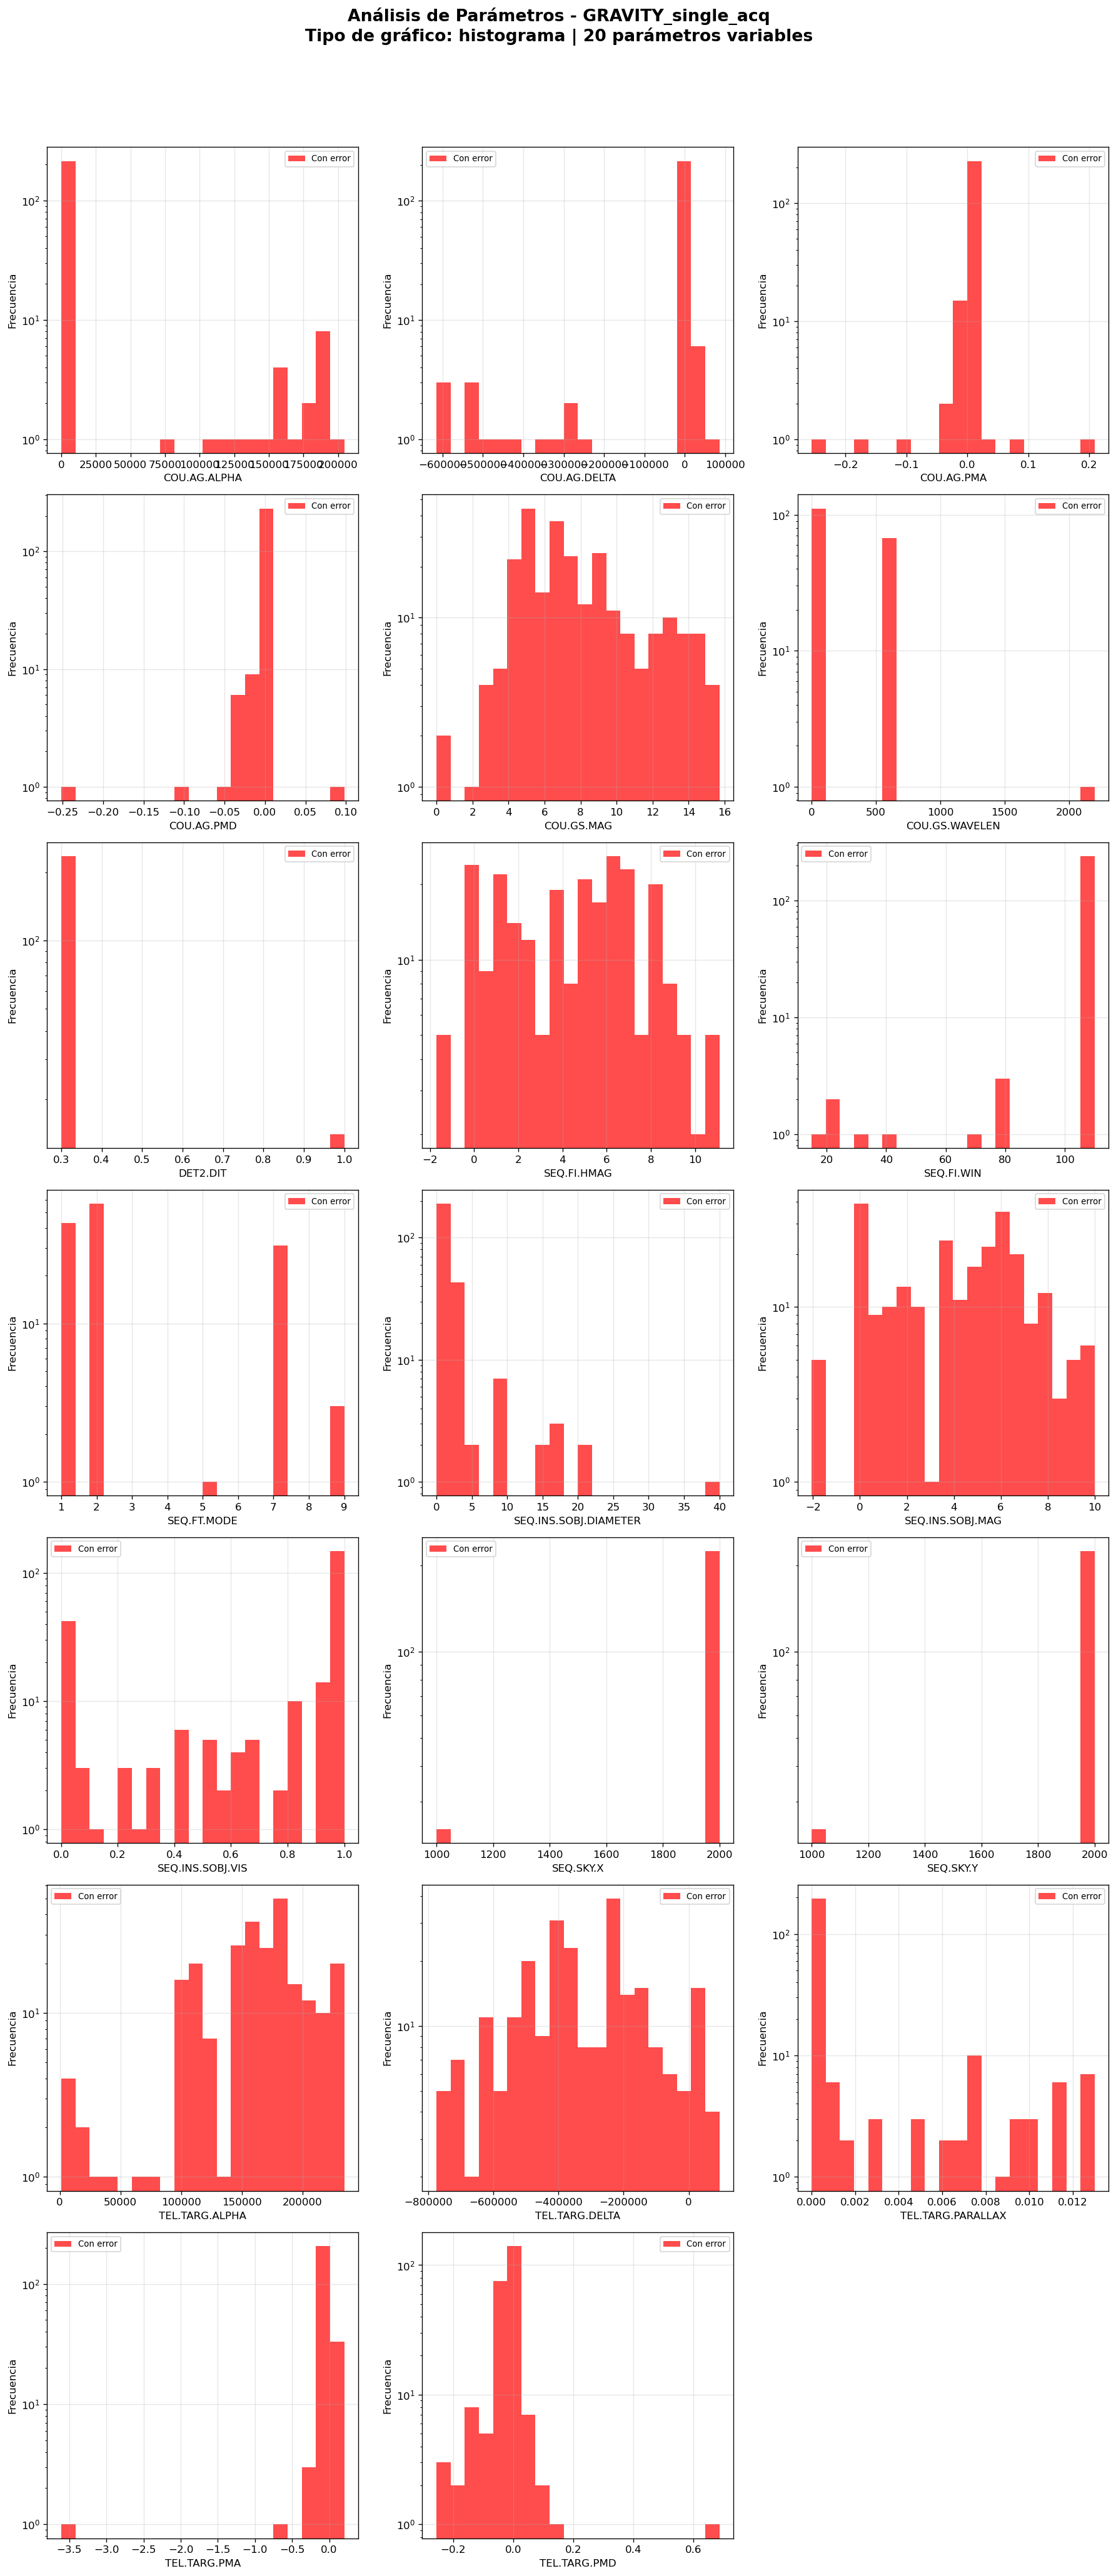

HISTOGRAMA guardado: figuras/GRAVITY_single_acq_hist.png
Creando gráficos tipo 'histograma' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.MINFTFLUX', 'SEQ.MINSCFLUX', 'SEQ.NOMPOS']
Todos los parámetros son constantes. No se generarán gráficos.
HISTOGRAMA guardado: figuras/GRAVITY_gen_cal_init_hist.png
Creando gráficos tipo 'histograma' para 27 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.GS.FWHM', 'DEL.REF.OPL', 'INS.STSOFFANG', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EQUINOX', 'TEL.TARG.RADVEL', 'TEL.TARG.WLENGTH']
Figura guardada en: figuras/GRAVITY_dual_acq_hist.png


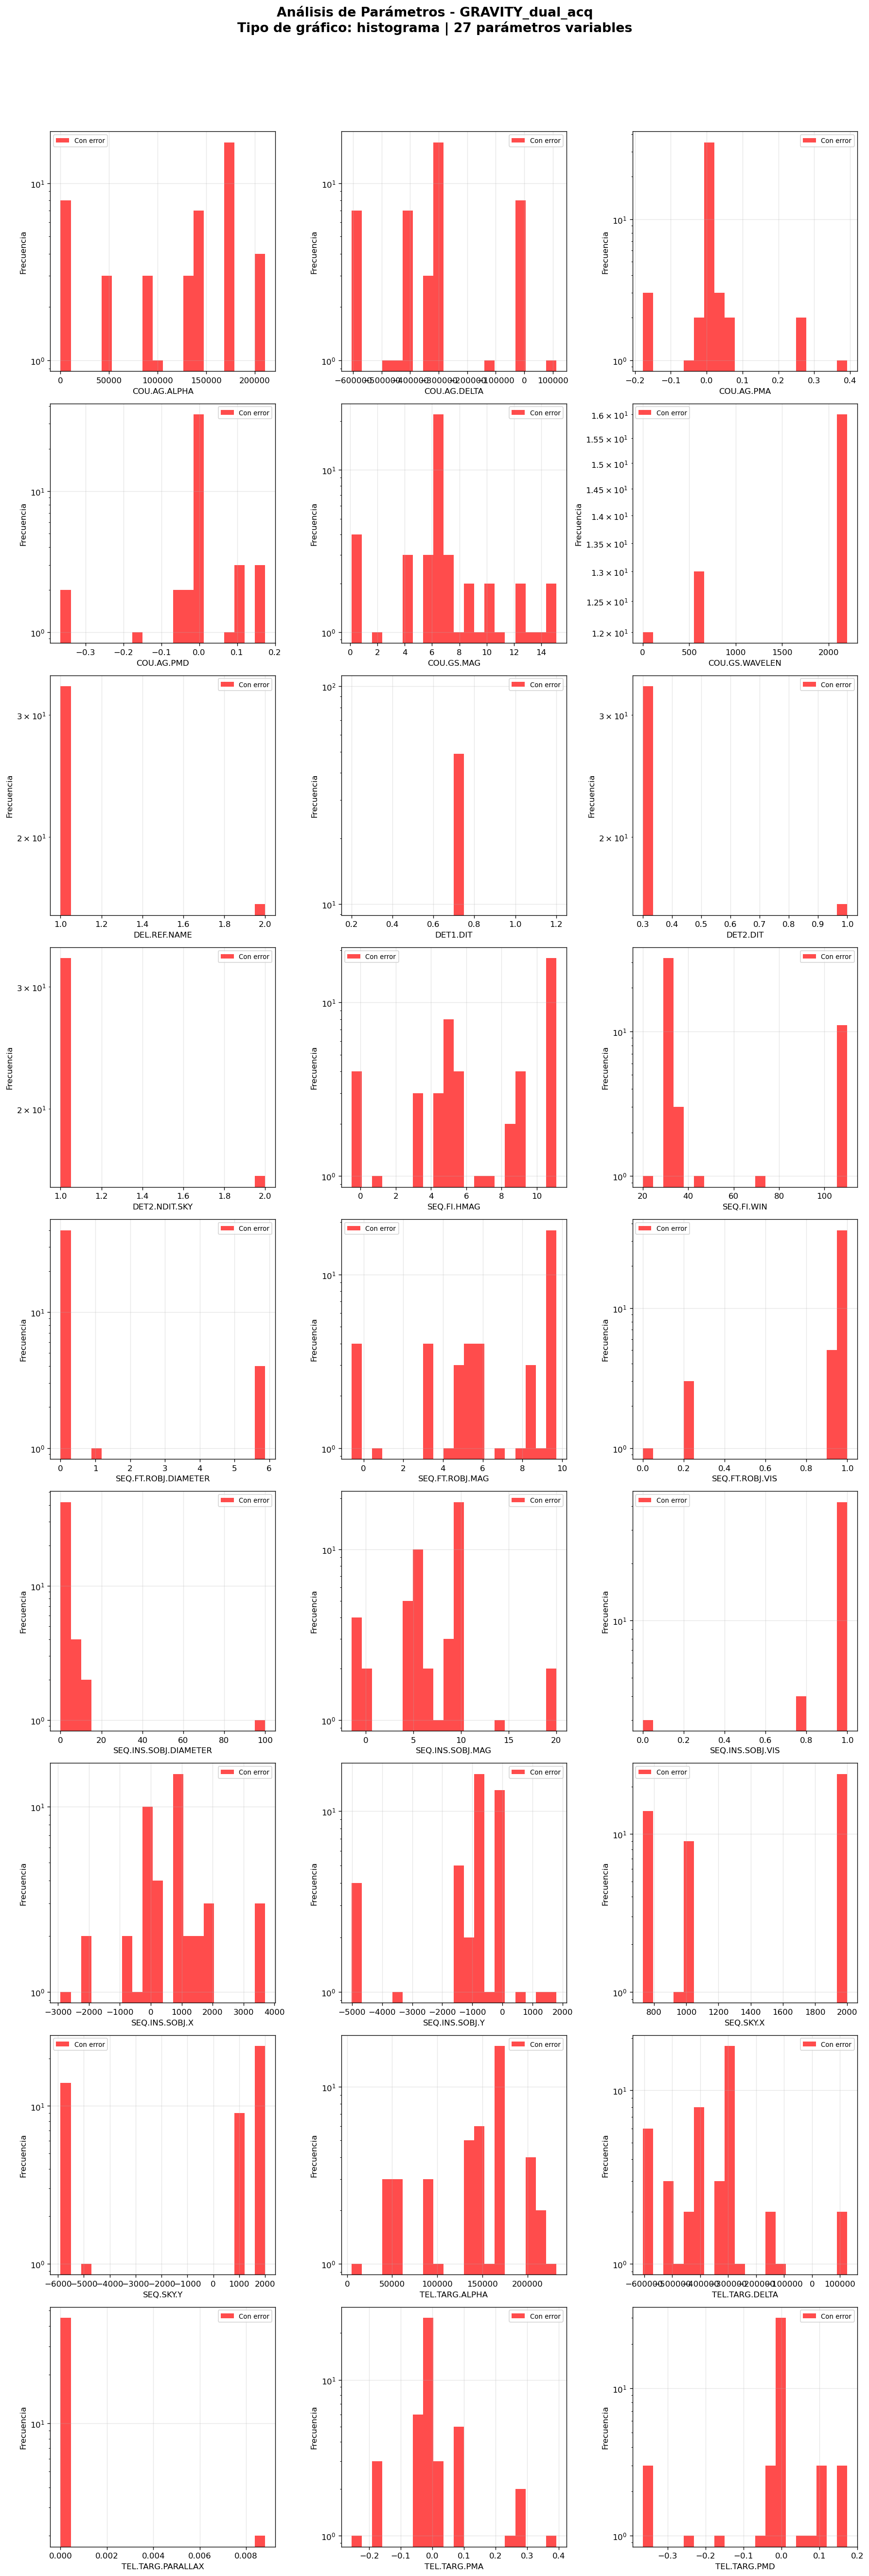

HISTOGRAMA guardado: figuras/GRAVITY_dual_acq_hist.png
Creando gráficos tipo 'histograma' para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.NDIT.OBJECT', 'DET2.NDIT.SKY', 'INS.LAMP4.INTENS1.ACQ', 'INS.LAMP4.INTENS1.SWAP', 'INS.LAMP4.INTENS2.ACQ', 'INS.LAMP4.INTENS2.SWAP', 'INS.POS1.ENCREL', 'INS.POS2.ENCREL', 'INS.POS3.ENCREL', 'INS.POS4.ENCREL', 'SEQ.DBWAITTIME', 'SEQ.DECREMENT_FACTOR', 'SEQ.MIN_STEP', 'SEQ.NOMPOS']
Figura guardada en: figuras/GRAVITY_gen_tec_checkMetZero_hist.png


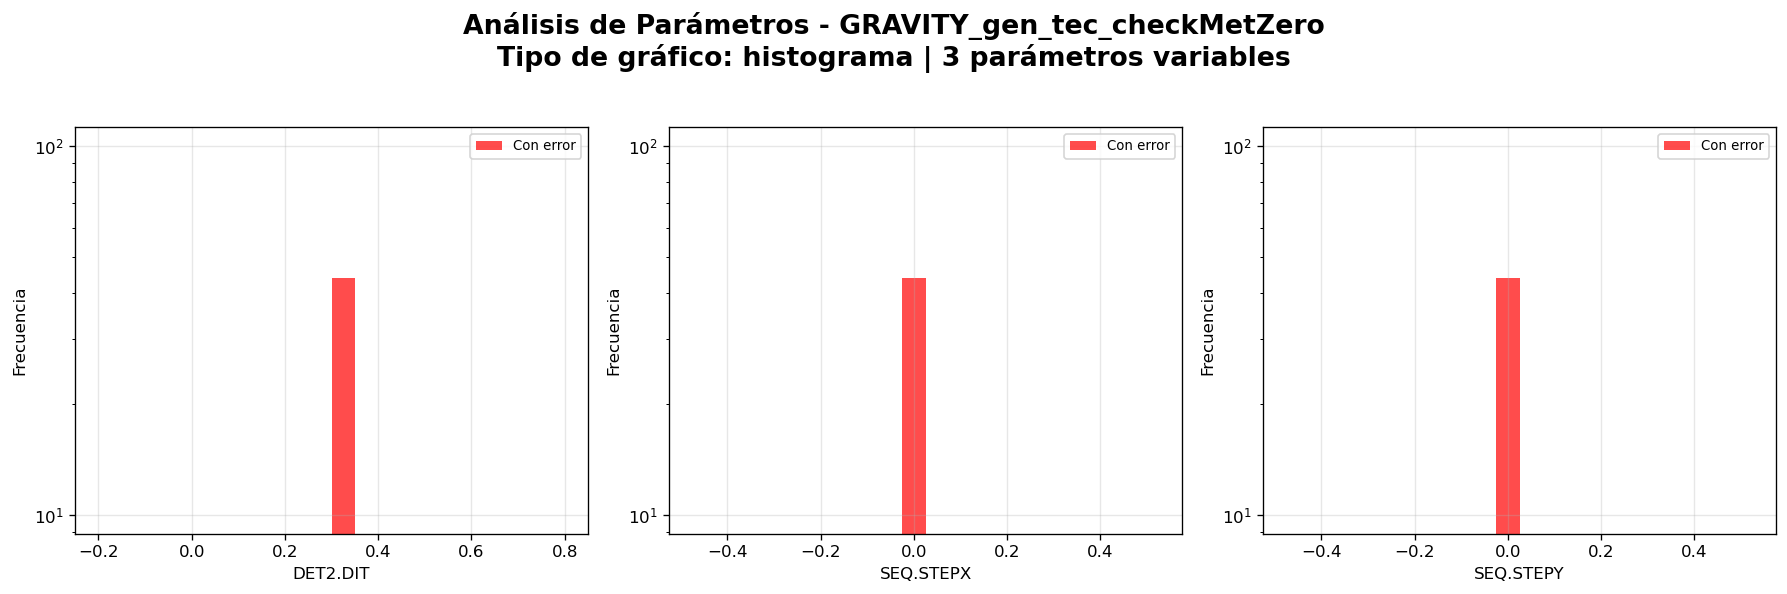

HISTOGRAMA guardado: figuras/GRAVITY_gen_tec_checkMetZero_hist.png
Creando gráficos tipo 'histograma' para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.HWPOFF']
Figura guardada en: figuras/GRAVITY_single_obs_exp_hist.png


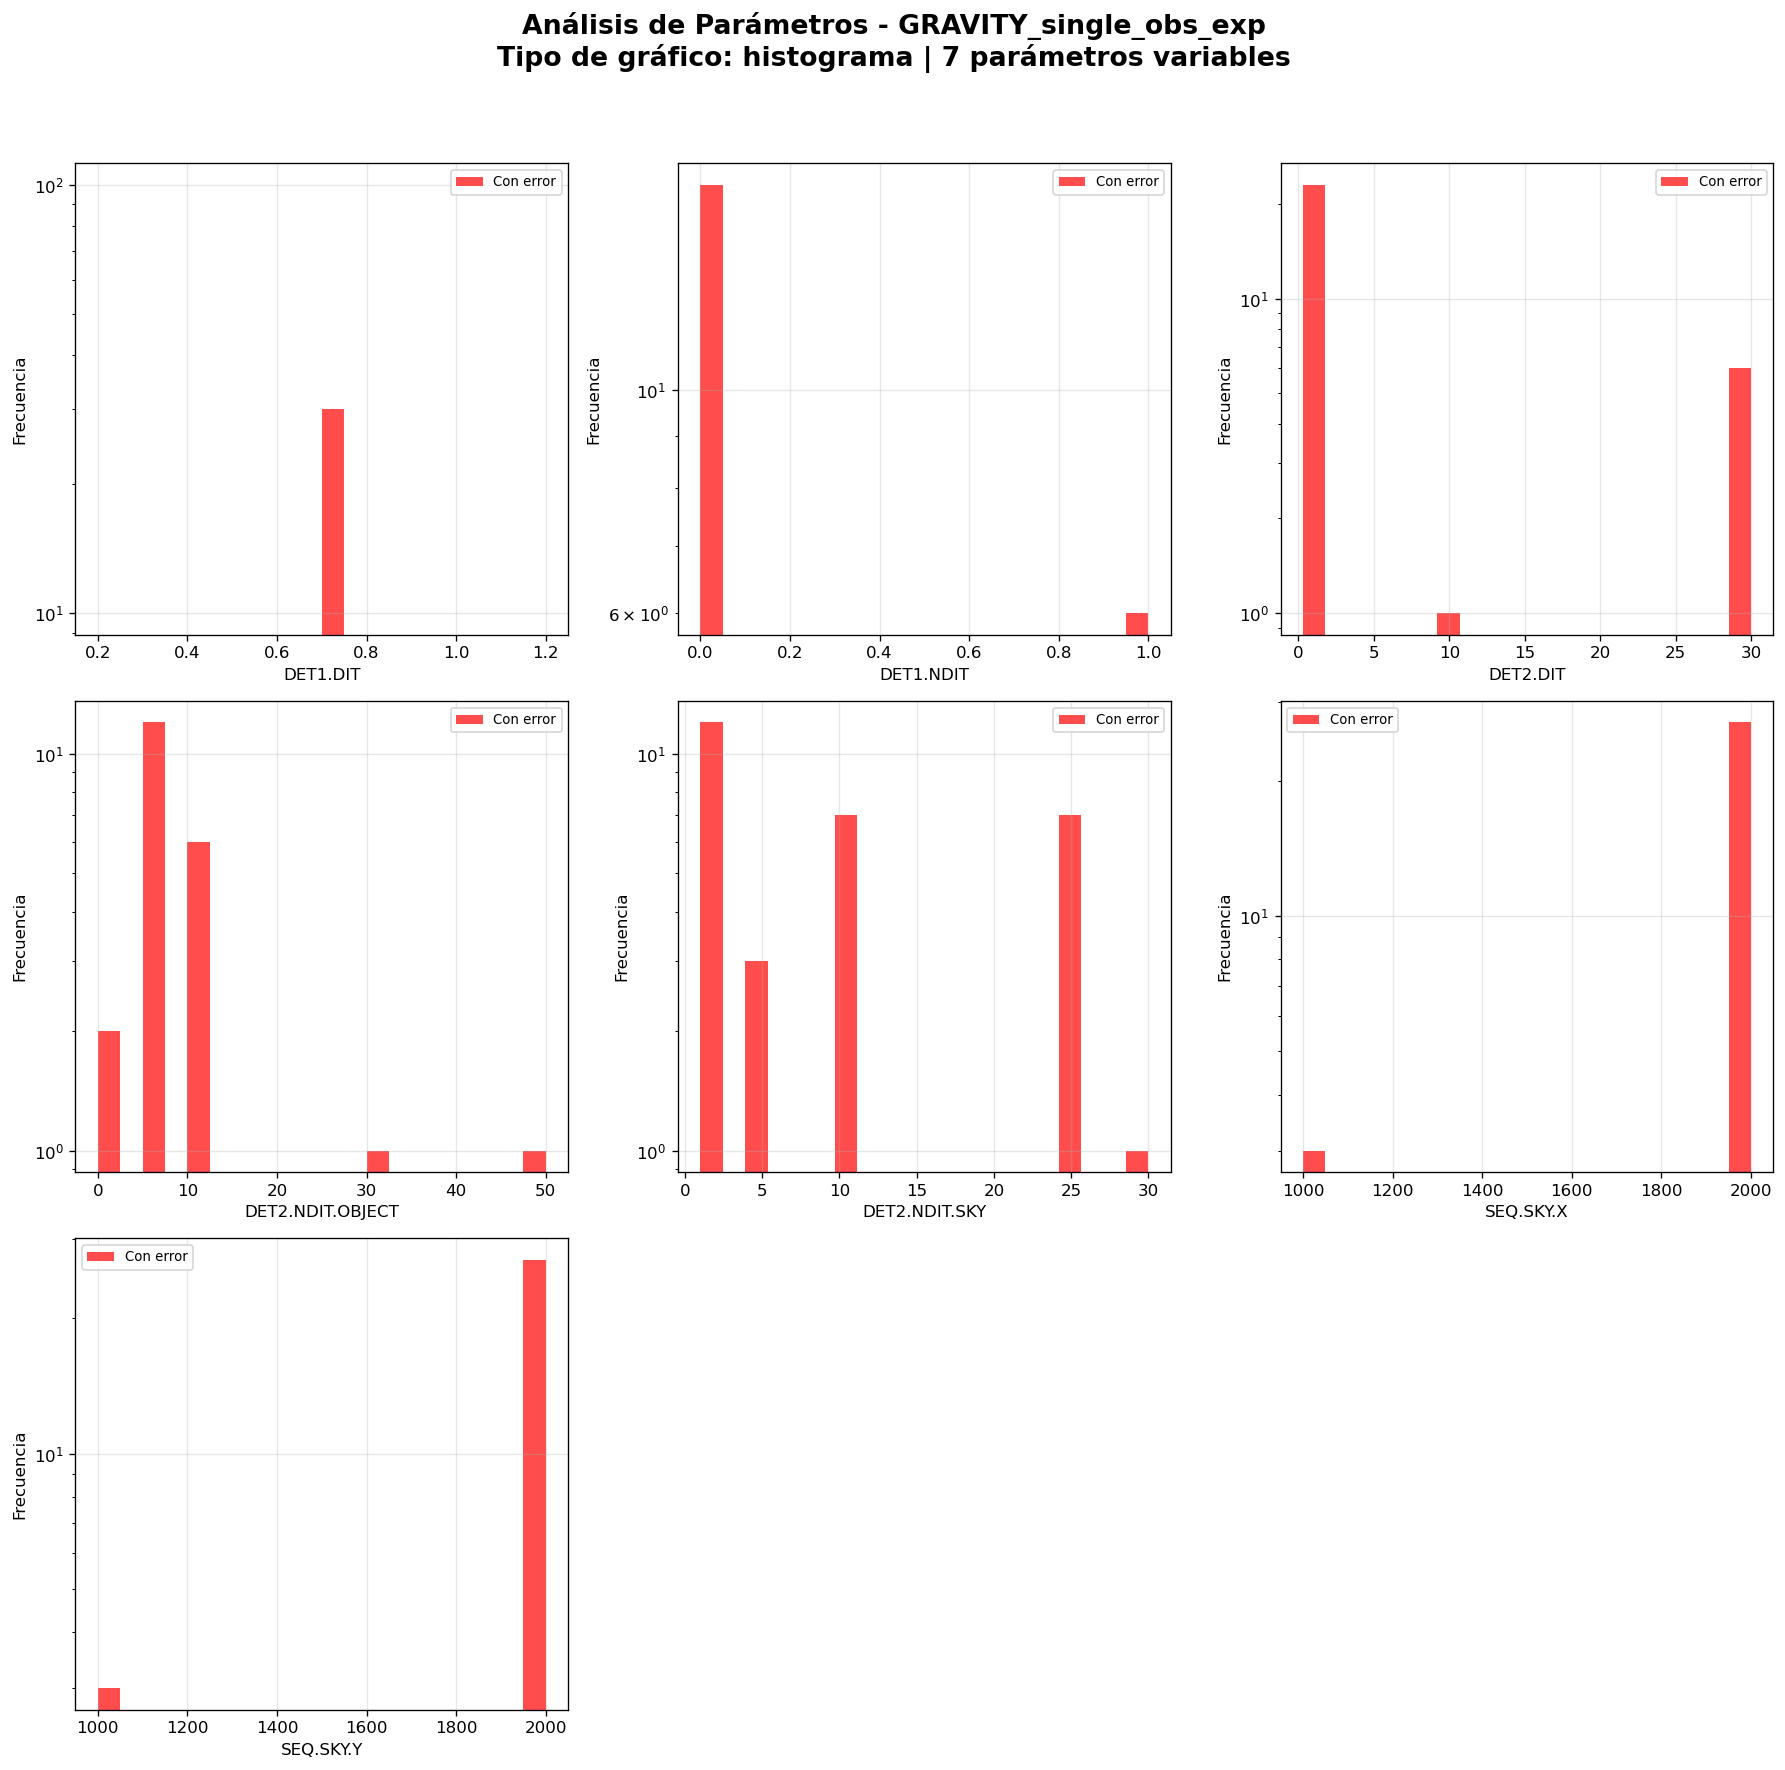

HISTOGRAMA guardado: figuras/GRAVITY_single_obs_exp_hist.png
Creando gráficos tipo 'histograma' para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.SKY.X']
Figura guardada en: figuras/GRAVITY_dual_obs_swap_hist.png


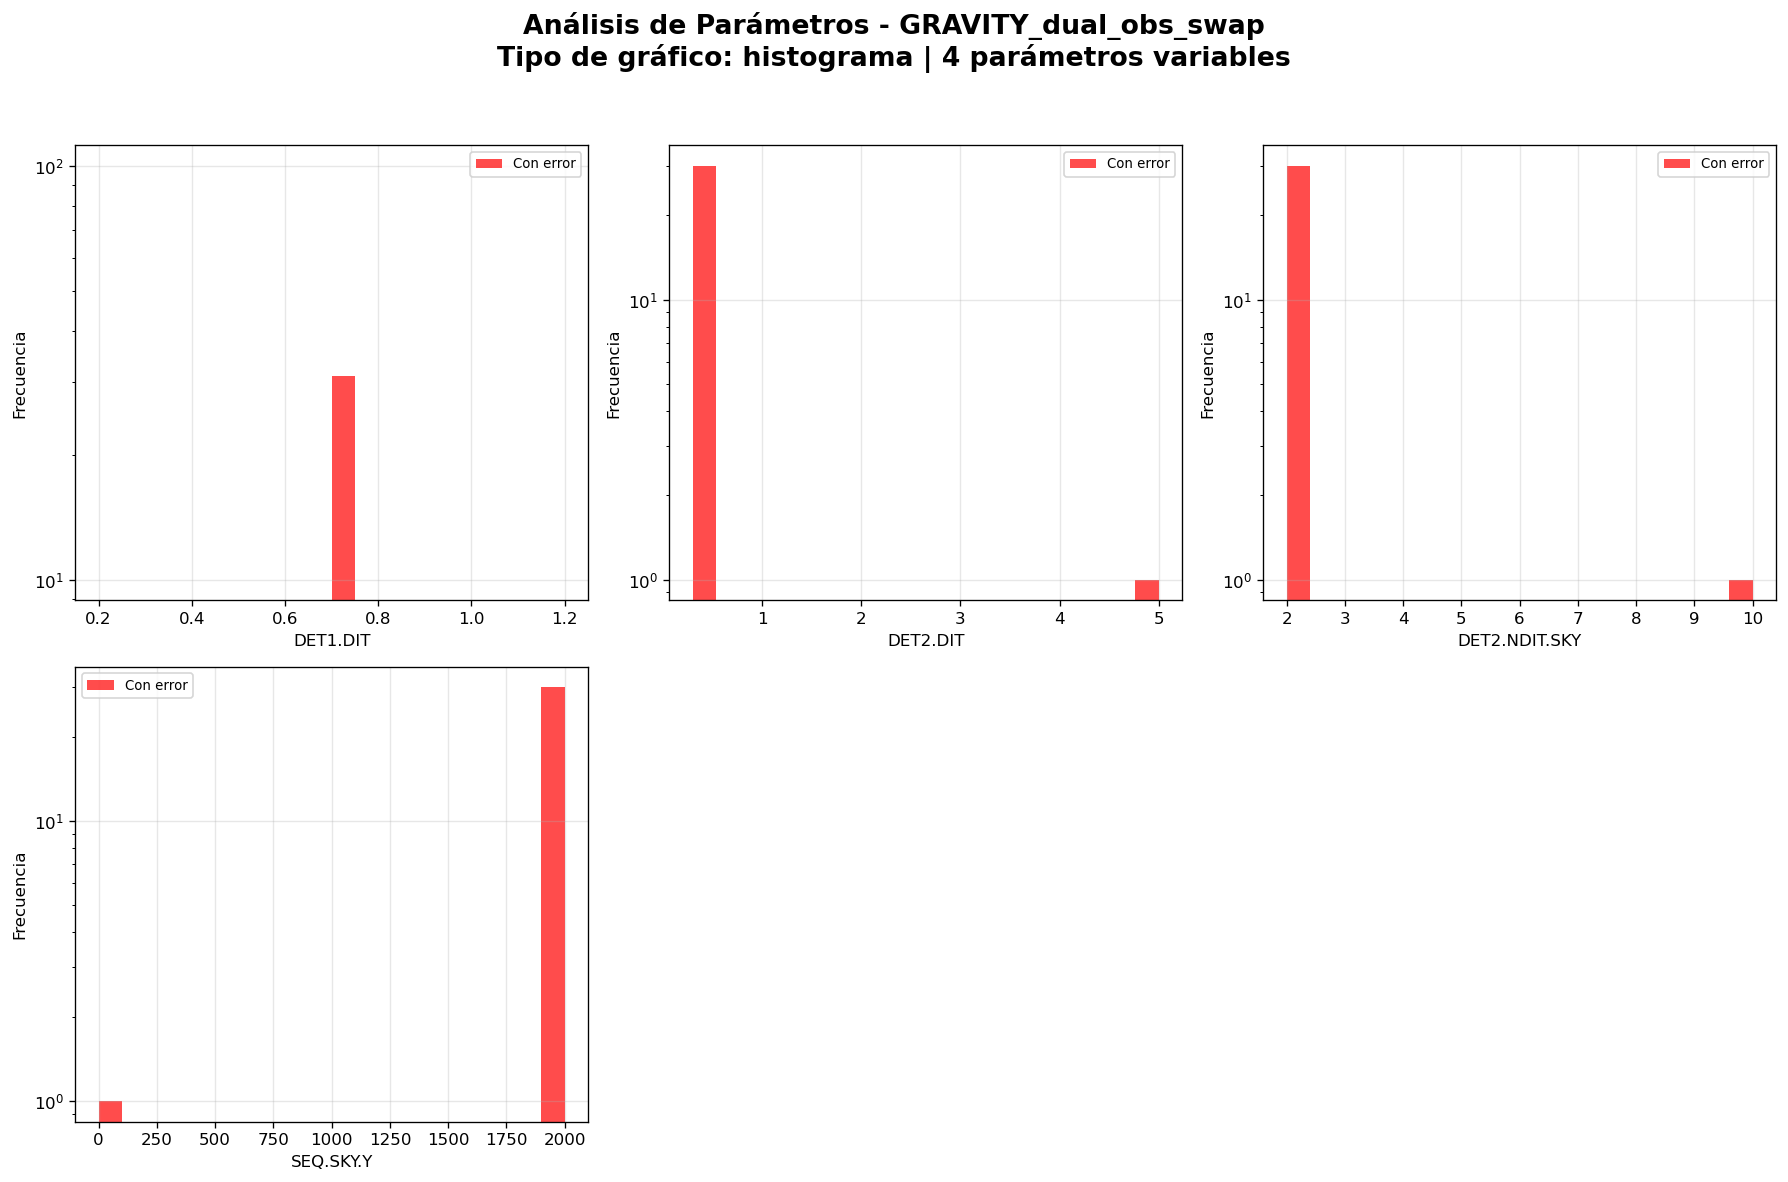

HISTOGRAMA guardado: figuras/GRAVITY_dual_obs_swap_hist.png
Creando gráficos tipo 'histograma' para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET2.NDIT.SKY', 'SEQ.DITHER.X', 'SEQ.DITHER.Y', 'SEQ.FI.WIN', 'SEQ.FT.ROBJ.DIAMETER', 'SEQ.FT.ROBJ.MAG', 'SEQ.FT.ROBJ.VIS', 'SEQ.INS.SOBJ.DIAMETER', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'SEQ.INS.SOBJ.VIS']
Figura guardada en: figuras/GRAVITY_dual_acq_dither_hist.png


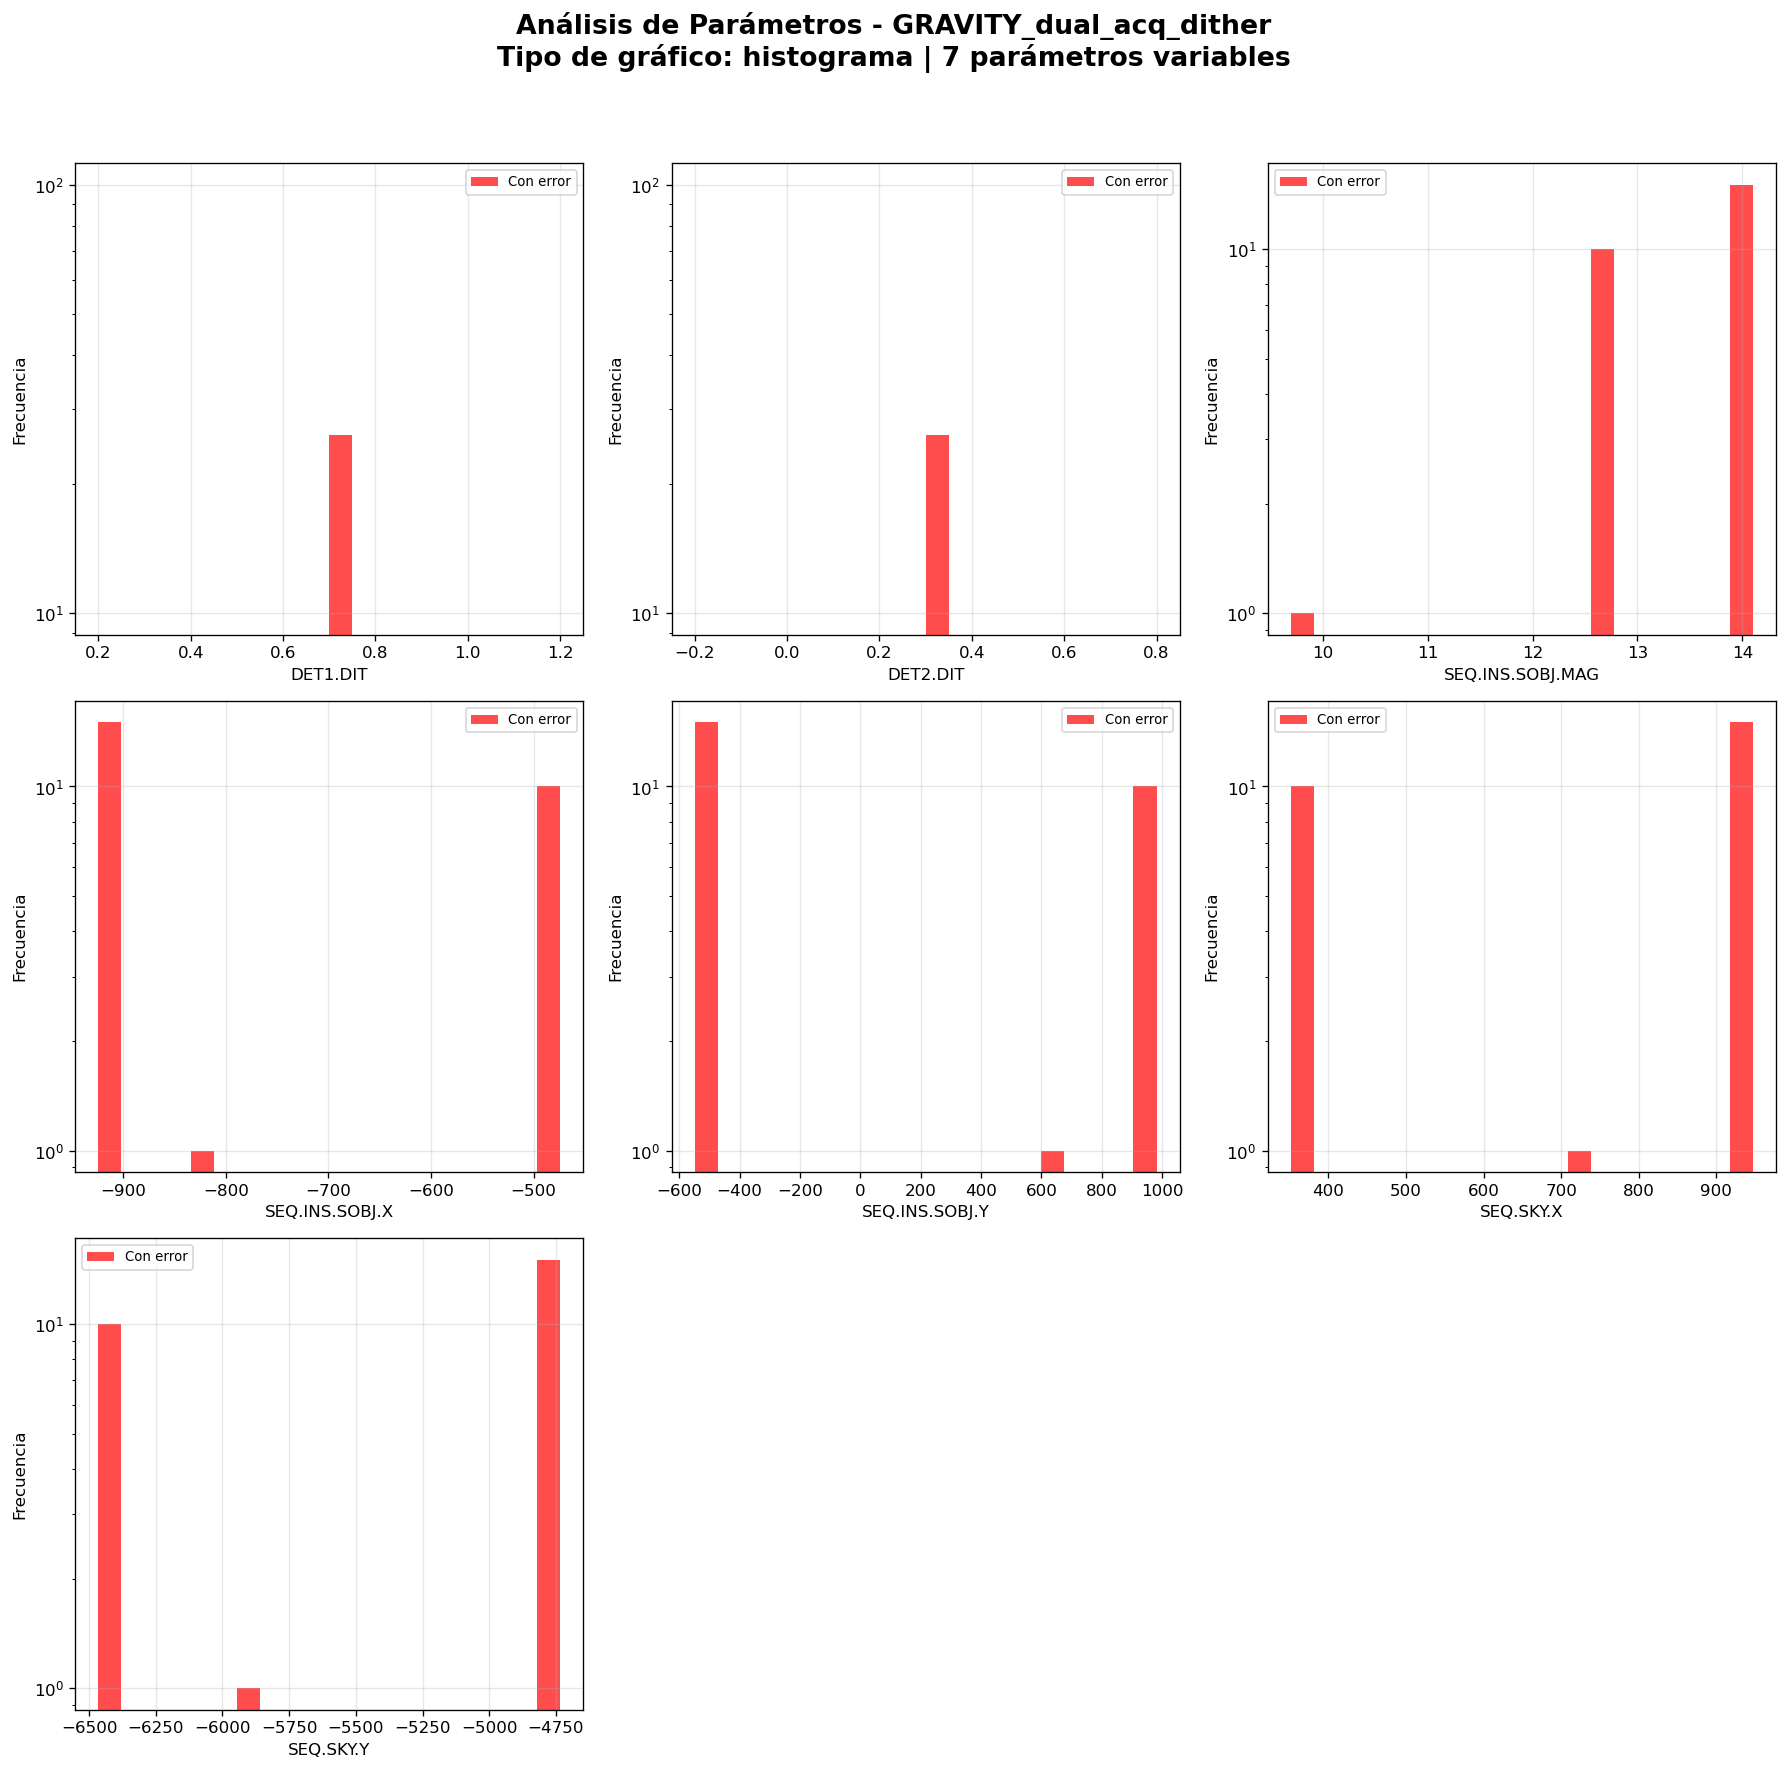

HISTOGRAMA guardado: figuras/GRAVITY_dual_acq_dither_hist.png


In [8]:
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl_id_str)

    if df_err is None or df_err.empty:
        print(f"{tpl_id_str}: DataFrame vacío. Se omite HISTOGRAMA.")
        continue

    df_err_num = df_err.apply(pd.to_numeric, errors="coerce")
    cols_num = sorted(df_err_num.select_dtypes(include="number").columns)

    if not cols_num:
        print(f"{tpl_id_str}: No hay columnas numéricas válidas para histograma.")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_hist.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_num[cols_num],
        nombre_archivo=tpl_id_str,
        tipo="histograma",
        log_y=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"HISTOGRAMA guardado: {ruta_png}")


## Análisis de parámetros categóricos

GRAVITY genera múltiples parámetros categóricos que representan estados,
configuraciones internas o modos de operación del instrumento.

Estos parámetros se:

1. codifican,
2. filtran (umbral de 50% máximo de `NaN`),
3. y preparan para visualización.

Los parámetros constantes o trivialmente repetidos se omiten.


In [9]:
tpl_strval_dict_err = {}

for tpl_id in df_meta['TPL_ID'].unique():
    strval_df_err = extract_trace_categoricals(
        df_meta,      # ya está filtrado con ERROR==True
        df_traces, 
        extract_params,
        tpl_id=tpl_id
    )

    if strval_df_err is not None and not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err

print(f"Se extrajeron parámetros categóricos para {len(tpl_strval_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros categóricos para 24 TPL_ID con errores.


In [10]:
codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada (solo errores).")
print(f"TPL_ID procesados: {len(codified_strval_err_dfs)}")



Codificación de categóricas completada (solo errores).
TPL_ID procesados: 24


## Clustering de observaciones con error (DBSCAN)

GRAVITY es el instrumento donde se observa la mayor diversidad de errores,
por lo que se aplica DBSCAN por cada `TPL_ID` que cumpla el mínimo de
observaciones con error (25 o más).  
El objetivo es identificar patrones de comportamiento anómalo dentro de cada
plantilla, usando únicamente los parámetros numéricos codificados.

El procedimiento es:

1. Imputación de valores faltantes mediante la mediana.
2. Normalización de parámetros numéricos (StandardScaler).
3. Aplicación de DBSCAN en el espacio original para obtener los clusters.
4. Proyección a 2 dimensiones mediante PCA con fines visuales.
5. Uso de *jitter* para evitar la superposición de puntos en la visualización.

La etiqueta `-1` corresponde a observaciones clasificadas como **ruido**, es decir,
puntos que DBSCAN no asocia a ningún grupo denso.  
Las etiquetas válidas se asignan a los grupos detectados y luego se integran al
artefacto final (`df_report`) para su análisis y visualización en el dashboard.


Creando gráficos tipo 'pie' para 19 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.OBJCNT', 'COU.AG.OPTIMIZE', 'COU.AG.PMA', 'COU.AG.PMD', 'COU.AG.START', 'COU.GS.FWHM', 'COU.GS.MAG', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.DIT', 'DET2.DIT', 'DET2.NDIT.SKY', 'INS.ACQ.FILTER', 'INS.STSOFFANG', 'SEQ.FI.HMAG', 'SEQ.FI.WIN', 'SEQ.FRINGETRACK', 'SEQ.FTOPT', 'SEQ.INS.SOBJ.DIAMETER', 'SEQ.INS.SOBJ.MAG', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'SEQ.INS.SOBJ.VIS', 'SEQ.LASERGUID', 'SEQ.OFFANG', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'SEQ.TRACKFI', 'SepTrackingCmd.ignored.because.PUPIL.TRACKING', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.ALPHA', 'TEL.TARG.COORDTYPE', 'TEL.TARG.DELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EPOCHSYSTEM', 'TEL.TARG.EQUINOX', 'TEL.TARG.PARALLAX', 'TEL.TARG.PMA', 'TEL.TARG.PMD', 'TEL.TARG.RADVEL', 'TEL.TARG.WLENGTH']
Figura guardada en: figuras/GRAVITY_single_acq_pie.png


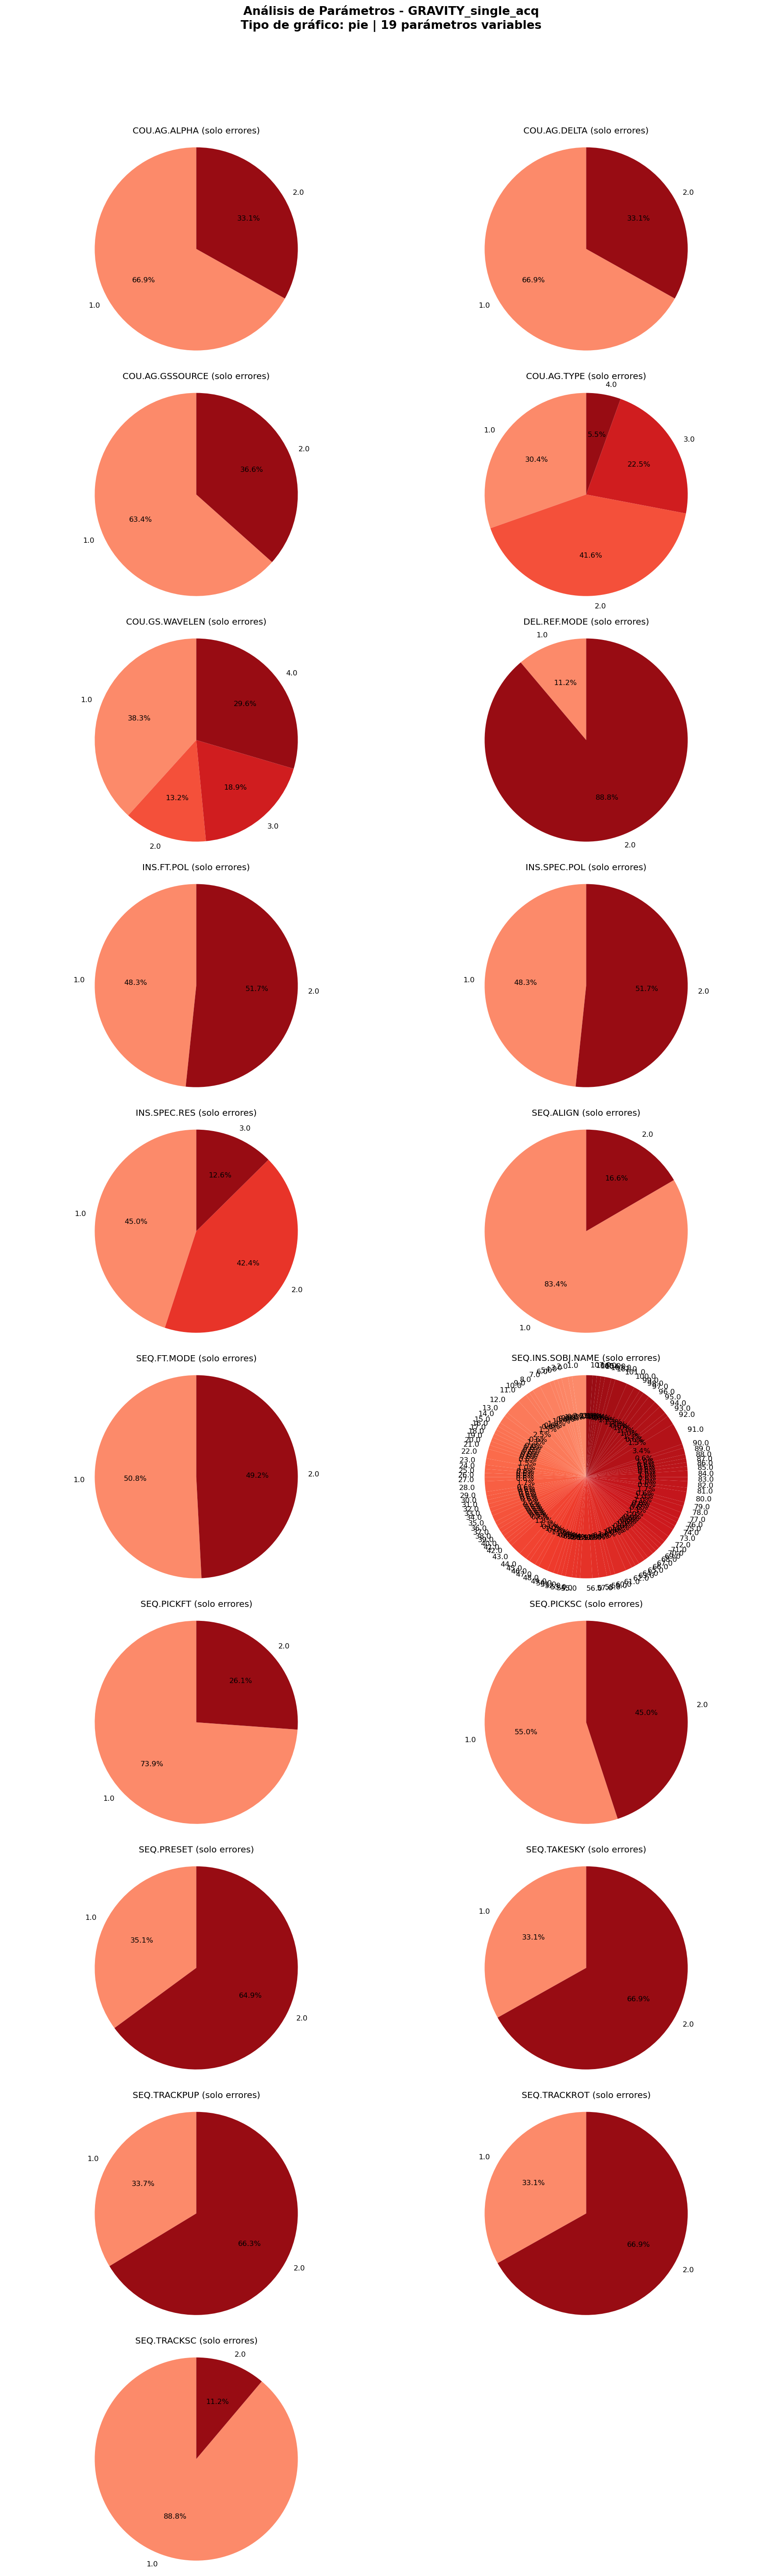

PIE guardado: figuras/GRAVITY_single_acq_pie.png
Creando gráficos tipo 'pie' para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.FT.POL', 'INS.MODE', 'INS.SPEC.POL', 'SEQ.AUTOPICK', 'SEQ.CLOSELOOPS', 'SEQ.COMMENT', 'SEQ.MINFTFLUX', 'SEQ.MINSCFLUX', 'SEQ.NOMPOS', 'SEQ.OPTFT', 'SEQ.OPTSC', 'SEQ.PRESET', 'SEQ.SEARCHFT', 'SEQ.SEARCHSC', 'SEQ.STARTMET', 'SEQ.TAKEDARK']
Figura guardada en: figuras/GRAVITY_gen_cal_init_pie.png


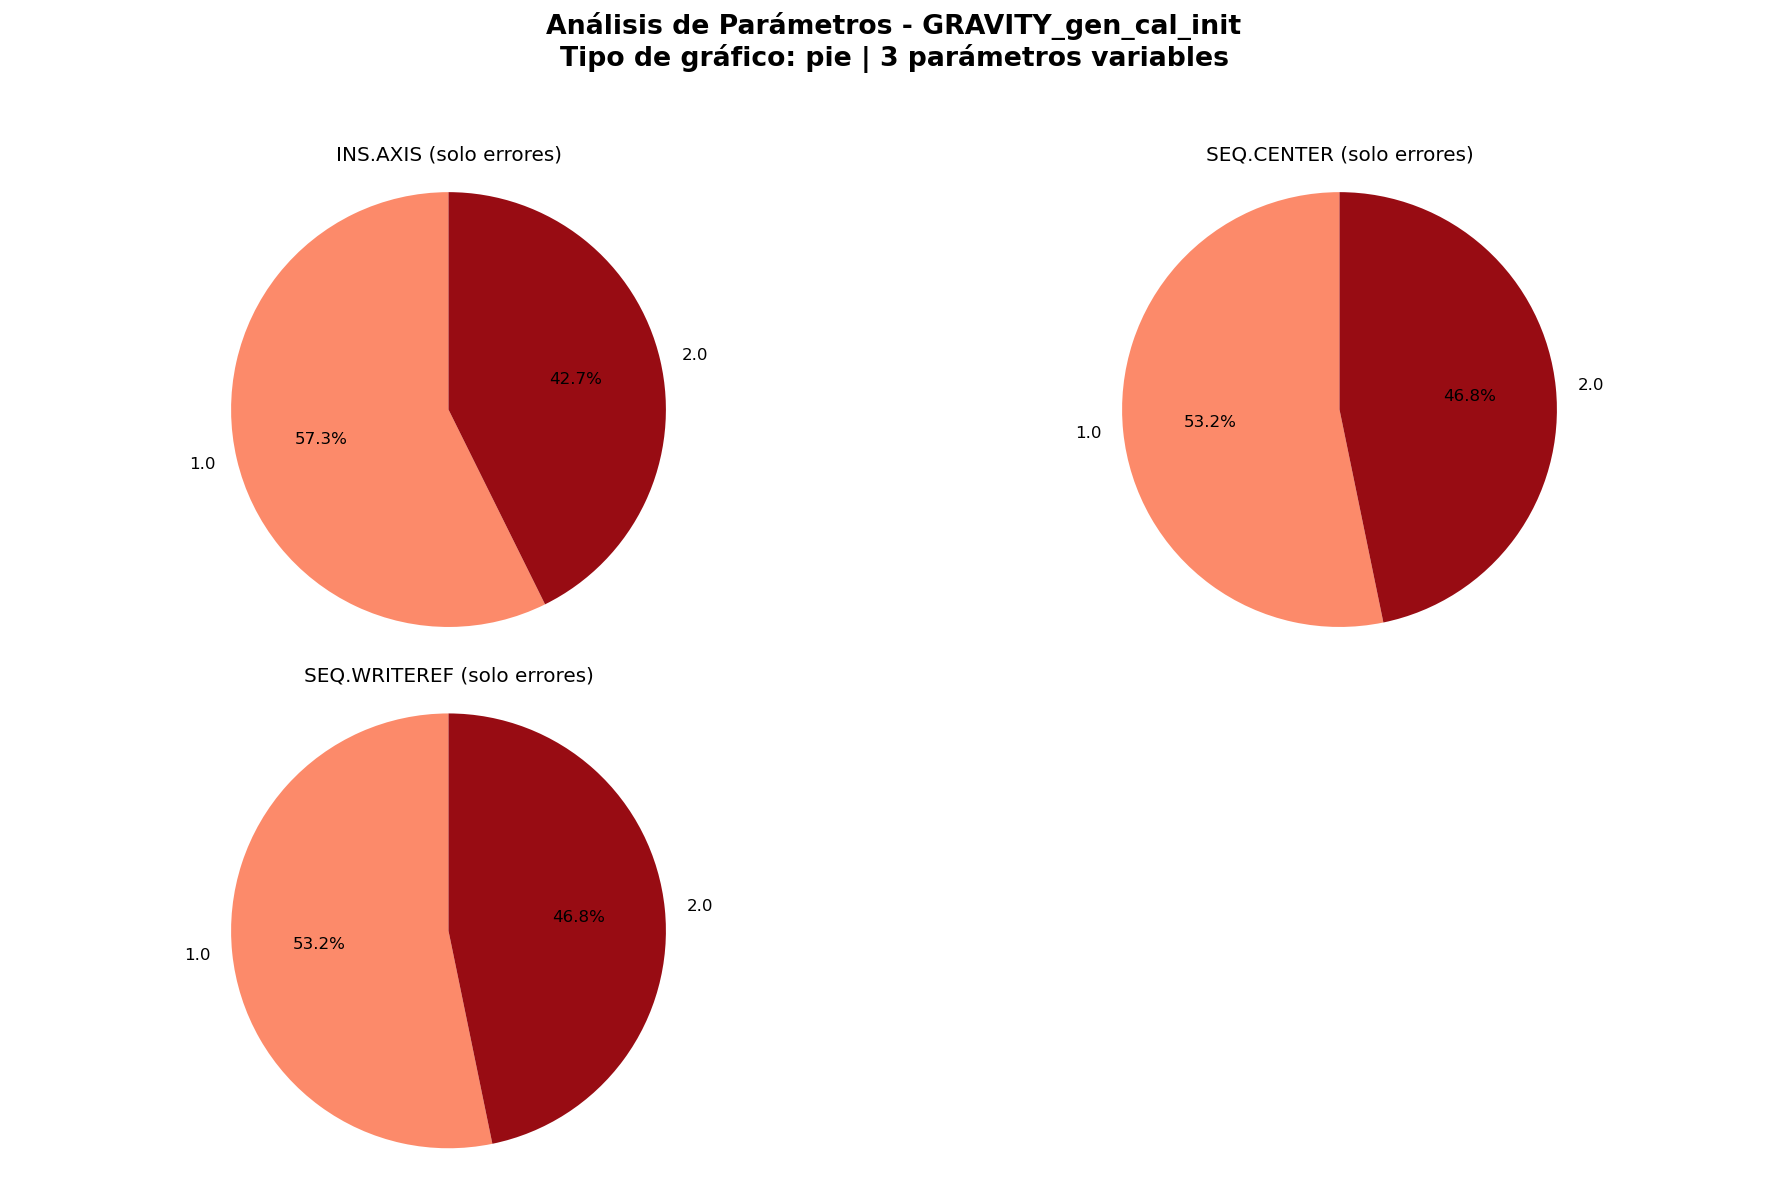

PIE guardado: figuras/GRAVITY_gen_cal_init_pie.png
Creando gráficos tipo 'pie' para 16 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.OBJCNT', 'COU.AG.OPTIMIZE', 'COU.AG.PMA', 'COU.AG.PMD', 'COU.AG.START', 'COU.GS.FWHM', 'COU.GS.MAG', 'DEL.REF.MODE', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.DIT', 'DET2.DIT', 'DET2.NDIT.SKY', 'INS.ACQ.FILTER', 'INS.STSOFFANG', 'SEQ.FI.HMAG', 'SEQ.FI.WIN', 'SEQ.FRINGETRACK', 'SEQ.FT.ROBJ.DIAMETER', 'SEQ.FT.ROBJ.MAG', 'SEQ.FT.ROBJ.VIS', 'SEQ.FTOPT', 'SEQ.INS.SOBJ.DIAMETER', 'SEQ.INS.SOBJ.MAG', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'SEQ.INS.SOBJ.VIS', 'SEQ.INS.SOBJ.X', 'SEQ.INS.SOBJ.Y', 'SEQ.LASERGUID', 'SEQ.OFFANG', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'SEQ.TAKESKY', 'SEQ.TRACKFI', 'SEQ.TRACKPUP', 'SEQ.TRACKROT', 'SepTrackingCmd.ignored.because.PUPIL.TRACKING', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.ALPHA', 'TEL.TARG.COORDTYPE', 'TEL.TARG.DELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EPOCHSYSTEM', 'TEL.TARG.EQUIN

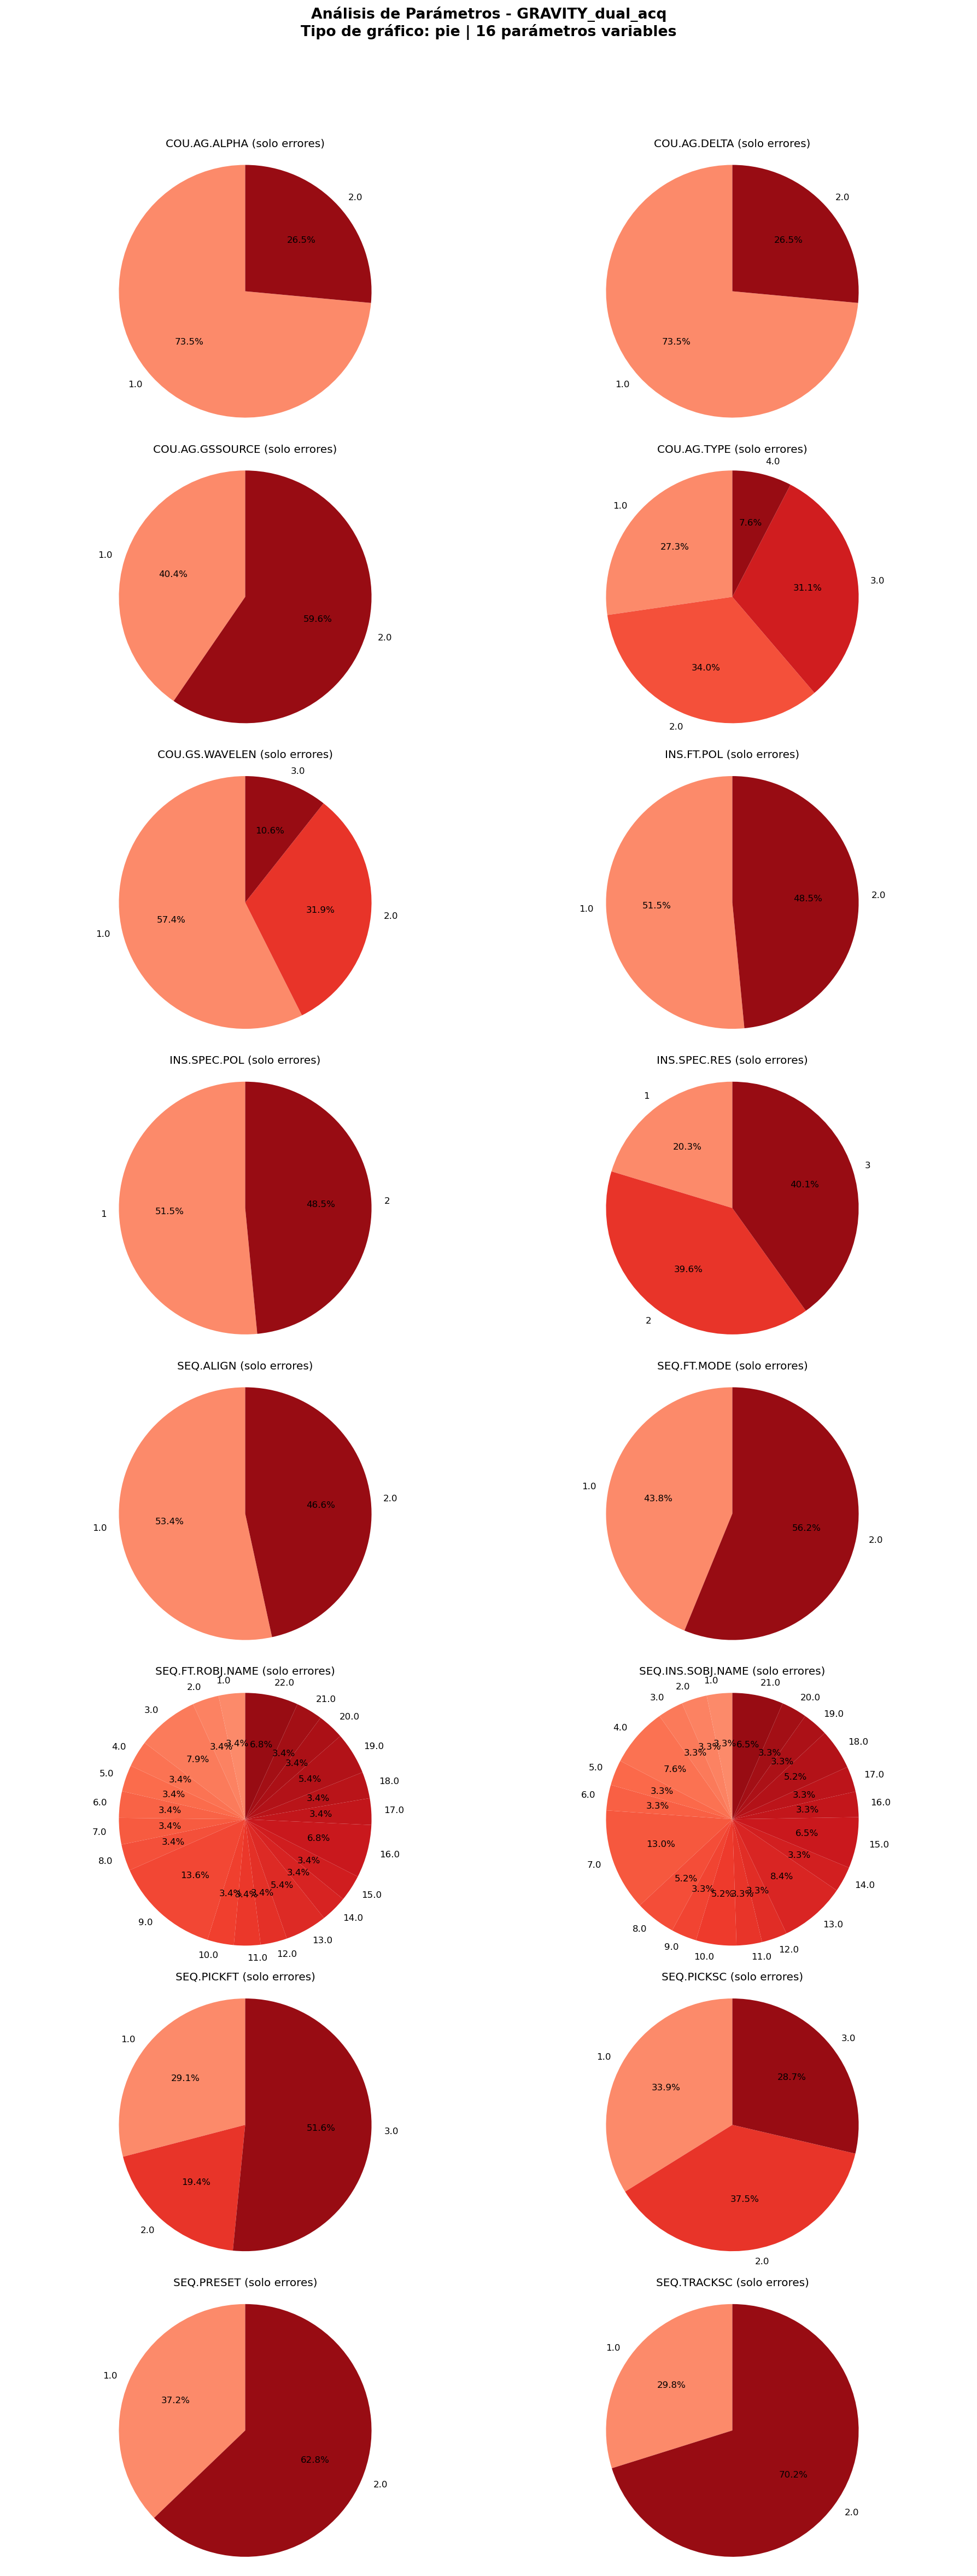

PIE guardado: figuras/GRAVITY_dual_acq_pie.png
Creando gráficos tipo 'pie' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.DIT', 'DET2.NDIT.OBJECT', 'DET2.NDIT.SKY', 'DPR.CATG', 'INS.LAMP4.INTENS1.ACQ', 'INS.LAMP4.INTENS1.SWAP', 'INS.LAMP4.INTENS2.ACQ', 'INS.LAMP4.INTENS2.SWAP', 'INS.POS1.ENCREL', 'INS.POS2.ENCREL', 'INS.POS3.ENCREL', 'INS.POS4.ENCREL', 'SEQ.DBWAITTIME', 'SEQ.DECREMENT_FACTOR', 'SEQ.MIN_STEP', 'SEQ.NOMPOS', 'SEQ.PRESET', 'SEQ.RECORD', 'SEQ.RETURN', 'SEQ.STEPX', 'SEQ.STEPY', 'SEQ.SYNCHRO', 'SEQ.WRITEREF']
Todos los parámetros son constantes. No se generarán gráficos.
PIE guardado: figuras/GRAVITY_gen_tec_checkMetZero_pie.png
Creando gráficos tipo 'pie' para 2 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.DIT', 'DET2.NDIT.OBJECT', 'DET2.NDIT.SKY', 'INS.SPEC.POL', 'INS.SPEC.RES', 'SEQ.COMMENT', 'SEQ.HWPOFF', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'SEQ.SYNCHRO']
Figura guardada en: figu

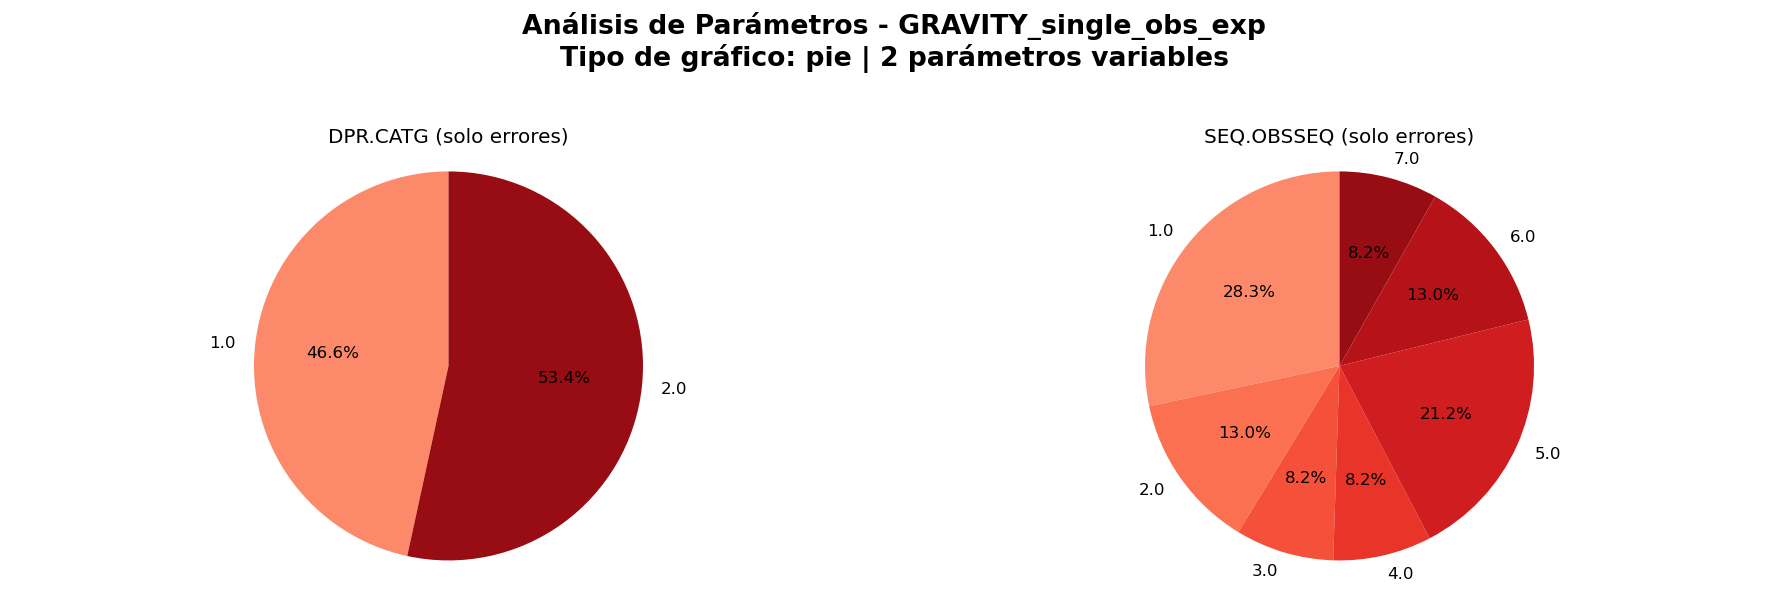

PIE guardado: figuras/GRAVITY_single_obs_exp_pie.png
Creando gráficos tipo 'pie' para 2 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET2.DIT', 'DET2.NDIT.SKY', 'SEQ.FRINGETRACK', 'SEQ.FT.MODE', 'SEQ.PICKFT', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'SEQ.SWAP', 'SEQ.TRACKFI', 'SEQ.TRACKPUP', 'SEQ.TRACKROT', 'SepTrackingCmd.ignored.because.PUPIL.TRACKING']
Figura guardada en: figuras/GRAVITY_dual_obs_swap_pie.png


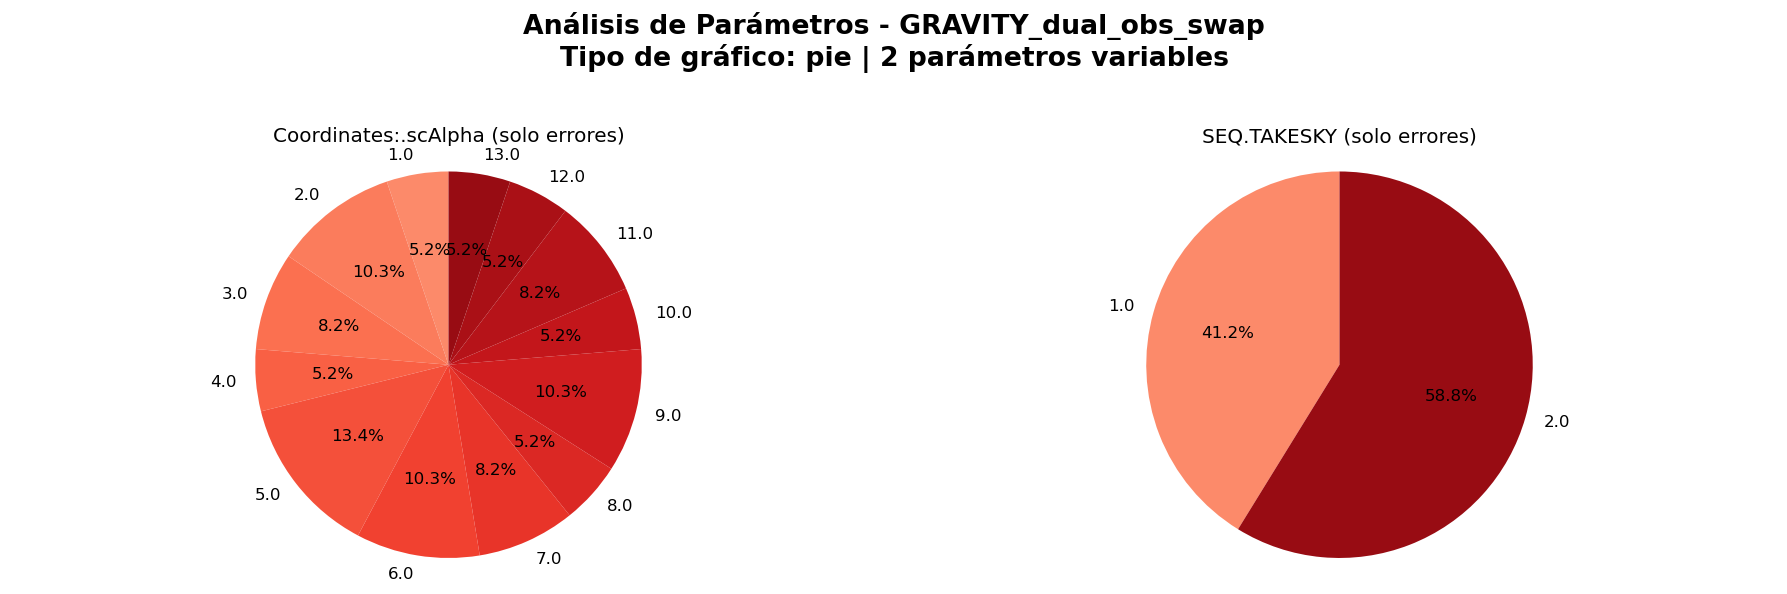

PIE guardado: figuras/GRAVITY_dual_obs_swap_pie.png
Creando gráficos tipo 'pie' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET2.DIT', 'DET2.NDIT.SKY', 'SEQ.DITHER.X', 'SEQ.DITHER.Y', 'SEQ.FI.WIN', 'SEQ.FT.MODE', 'SEQ.FT.ROBJ.DIAMETER', 'SEQ.FT.ROBJ.MAG', 'SEQ.FT.ROBJ.NAME', 'SEQ.FT.ROBJ.VIS', 'SEQ.INS.SOBJ.DIAMETER', 'SEQ.INS.SOBJ.MAG', 'SEQ.INS.SOBJ.PMA', 'SEQ.INS.SOBJ.PMD', 'SEQ.INS.SOBJ.RADVEL', 'SEQ.INS.SOBJ.VIS', 'SEQ.INS.SOBJ.X', 'SEQ.INS.SOBJ.Y', 'SEQ.PICKFT', 'SEQ.PICKSC', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'SEQ.TAKESKY', 'SEQ.TRACKROT', 'SEQ.TRACKSC', 'SepTrackingCmd.ignored.because.PUPIL.TRACKING']
Figura guardada en: figuras/GRAVITY_dual_acq_dither_pie.png


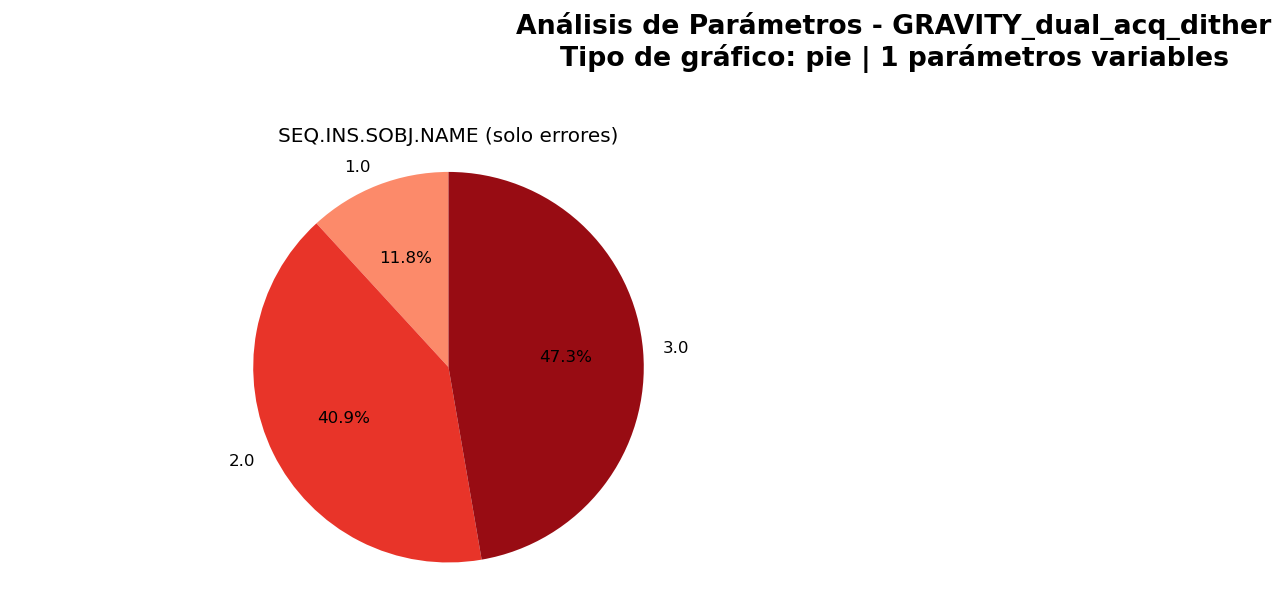

PIE guardado: figuras/GRAVITY_dual_acq_dither_pie.png


In [11]:
THRESHOLD_NAN = 0.5
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err_codified = codified_strval_err_dfs.get(tpl_id_str)

    if df_err_codified is None or df_err_codified.empty:
        print(f"{tpl_id_str}: DataFrame vacío o inexistente. Se omite PIE.")
        continue

    df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < THRESHOLD_NAN]
    df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < THRESHOLD_NAN, :]

    if df_err_cleaned.empty:
        print(f"{tpl_id_str}: DataFrame vacío después de la limpieza. Se omite PIE.")
        continue

    columns = sorted(df_err_cleaned.columns)
    if not columns:
        print(f"{tpl_id_str}: No hay columnas válidas después de la limpieza (PIE).")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_pie.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_cleaned[columns],
        nombre_archivo=tpl_id_str,
        tipo="pie",
        use_log=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"PIE guardado: {ruta_png}")




## Clustering de observaciones con error (DBSCAN)

GRAVITY es el instrumento donde se espera observar mayor diversidad de errores.
Por ello se aplica DBSCAN a los parámetros numéricos normalizados de cada
`TPL_ID` con al menos 25 errores.

El proceso es:

1. Imputación de valores faltantes (mediana).
2. Normalización de parámetros (StandardScaler).
3. Ejecución de DBSCAN en el espacio original de parámetros.
4. Reducción de la dimensión a 2 componentes (PCA) solo para visualizar.
5. Uso de *jitter* para evitar solapamiento entre puntos.

La etiqueta `-1` corresponde a observaciones clasificadas como **ruido**,
esto es, puntos que no pertenecen a ningún grupo denso según DBSCAN.



Clustering (solo errores) → GRAVITY_single_acq
DBSCAN params: {'eps': np.float64(2.216403090386345), 'min_samples': 7, 'n': 250, 'p': 20}
Conteo de clusters:
cluster
 1    77
-1    61
 0    36
 5    25
 3    16
 7    14
 2     7
 4     7
 6     7
Name: count, dtype: int64
Cluster guardado en: figuras/GRAVITY_single_acq_cluster.png


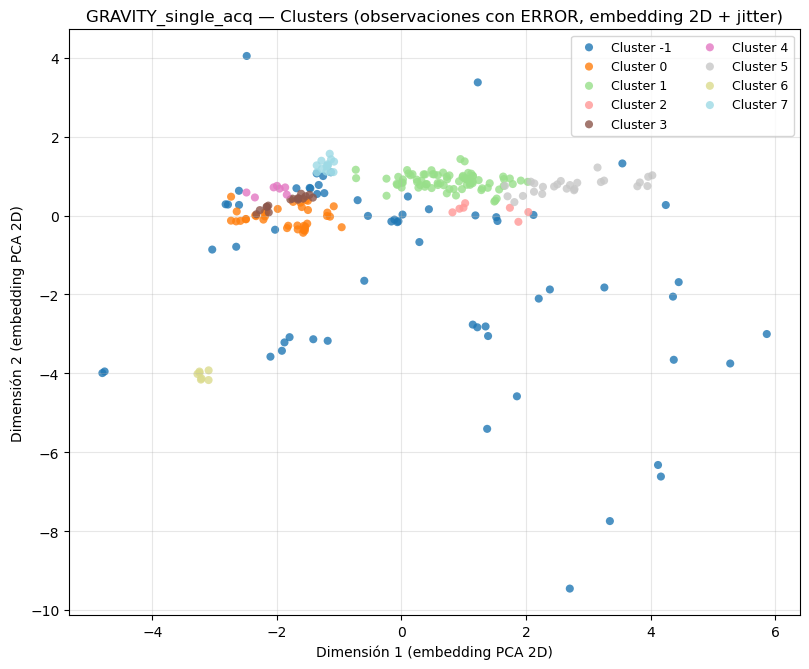

CLUSTER guardado: figuras/GRAVITY_single_acq_cluster.png

Clustering (solo errores) → GRAVITY_gen_cal_init
Todas las columnas son constantes tras limpieza. Se omite este TPL_ID.
GRAVITY_gen_cal_init: sin datos utilizables después de la limpieza. Se omite CLUSTER.

Clustering (solo errores) → GRAVITY_dual_acq
DBSCAN params: {'eps': np.float64(1.2138484207220894), 'min_samples': 5, 'n': 49, 'p': 26}
Conteo de clusters:
cluster
-1    35
 0    14
Name: count, dtype: int64
Cluster guardado en: figuras/GRAVITY_dual_acq_cluster.png


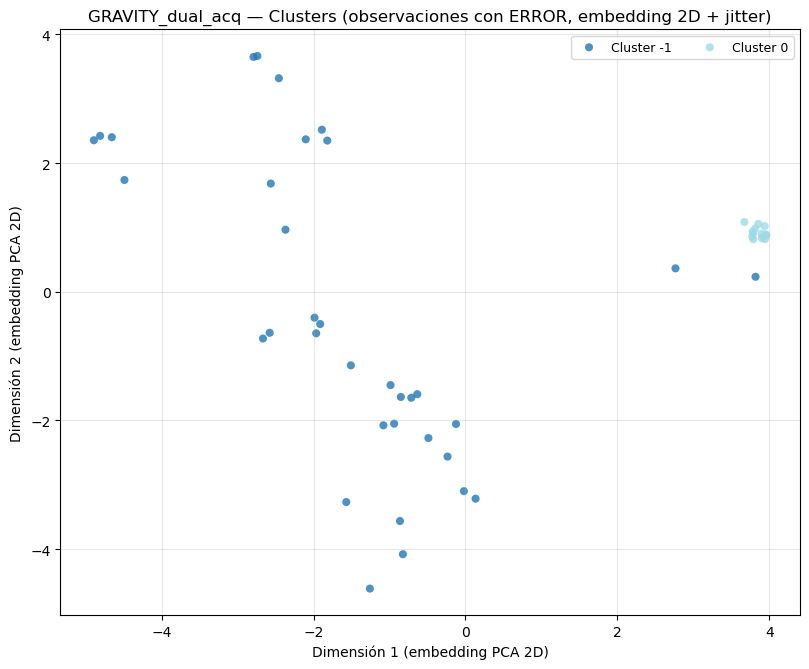

CLUSTER guardado: figuras/GRAVITY_dual_acq_cluster.png

Clustering (solo errores) → GRAVITY_gen_tec_checkMetZero
Todas las columnas son constantes tras limpieza. Se omite este TPL_ID.
GRAVITY_gen_tec_checkMetZero: sin datos utilizables después de la limpieza. Se omite CLUSTER.

Clustering (solo errores) → GRAVITY_single_obs_exp
DBSCAN params: {'eps': np.float64(0.9978733714136185), 'min_samples': 4, 'n': 30, 'p': 6}
Conteo de clusters:
cluster
 0    9
 2    7
-1    6
 1    4
 3    4
Name: count, dtype: int64
Cluster guardado en: figuras/GRAVITY_single_obs_exp_cluster.png


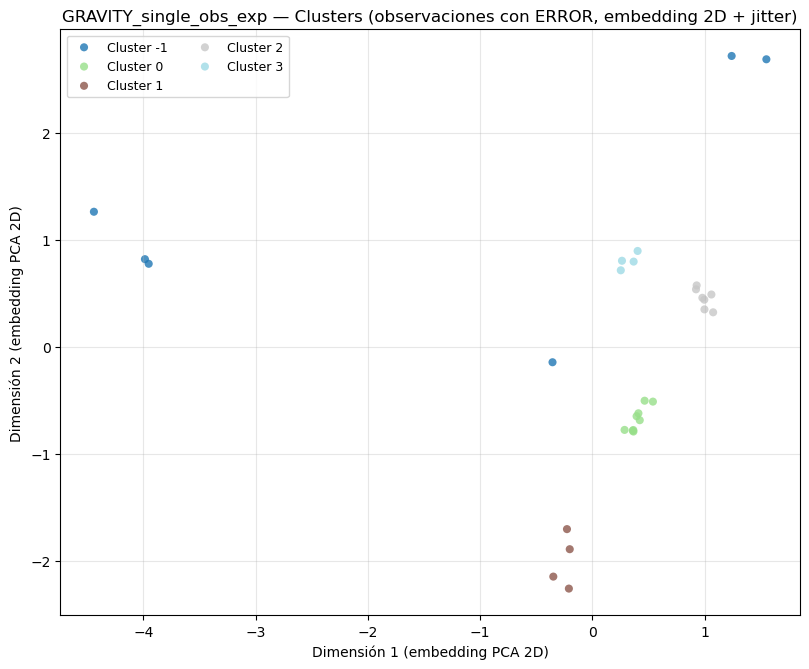

CLUSTER guardado: figuras/GRAVITY_single_obs_exp_cluster.png

Clustering (solo errores) → GRAVITY_dual_obs_swap
DBSCAN params: {'eps': np.float64(1.697939928266015), 'min_samples': 4, 'n': 31, 'p': 3}
Conteo de clusters:
cluster
 0    30
-1     1
Name: count, dtype: int64
Cluster guardado en: figuras/GRAVITY_dual_obs_swap_cluster.png


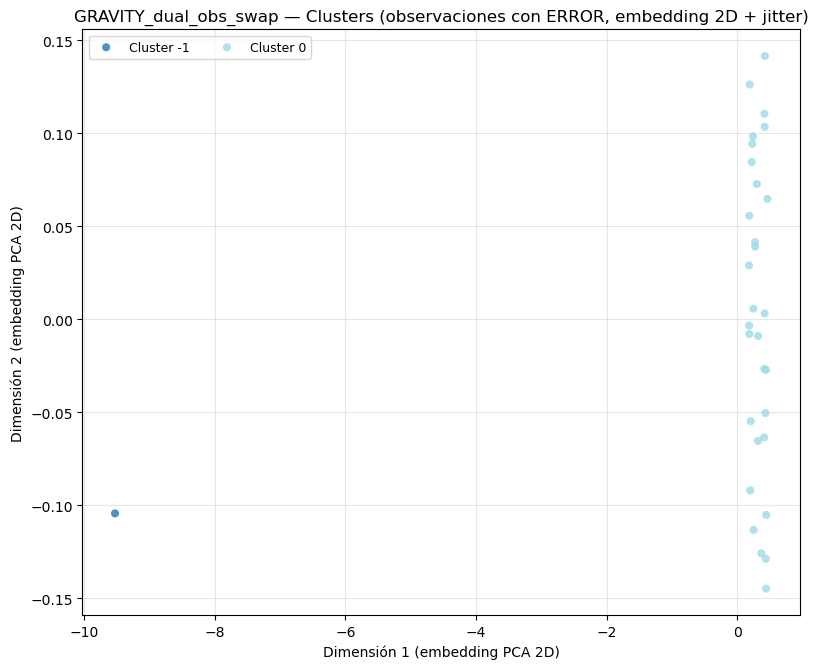

CLUSTER guardado: figuras/GRAVITY_dual_obs_swap_cluster.png

Clustering (solo errores) → GRAVITY_dual_acq_dither
DBSCAN params: {'eps': np.float64(0.7642663614161254), 'min_samples': 4, 'n': 26, 'p': 5}
Conteo de clusters:
cluster
 1    15
 0    10
-1     1
Name: count, dtype: int64
Cluster guardado en: figuras/GRAVITY_dual_acq_dither_cluster.png


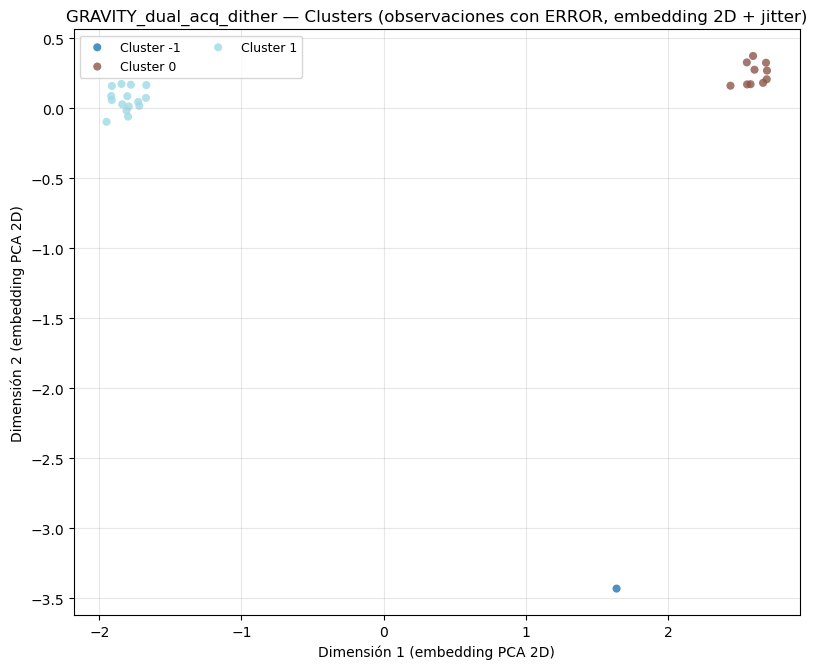

CLUSTER guardado: figuras/GRAVITY_dual_acq_dither_cluster.png


In [12]:
CARPETA_FIG = "figuras"

res_por_tpl = {}

for tpl in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl)

    if df_err is None or df_err.empty:
        print(f"{tpl}: DataFrame vacío. Se omite CLUSTER.")
        continue

    print(f"\nClustering (solo errores) → {tpl}")
    df_res, dbp = cluster_todos_en_conjunto(None, df_err)

    if df_res.empty:
        print(f"{tpl}: sin datos utilizables después de la limpieza. Se omite CLUSTER.")
        continue

    res_por_tpl[tpl] = df_res.copy()

    print("DBSCAN params:", dbp)
    print("Conteo de clusters:")
    print(df_res["cluster"].value_counts())

    ruta_png = f"{CARPETA_FIG}/{tpl}_cluster.png"

    plot_clusters_por_cluster_y_origen(
        df_res,
        titulo=f"{tpl} — Clusters (observaciones con ERROR, embedding 2D + jitter)",
        jitter=0.15,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"CLUSTER guardado: {ruta_png}")

## Construcción del artefacto final `df_report`

Para cada `TPL_ID` se alinean los índices entre metadatos (`df_meta`), parámetros con error
(`df_err`) y resultados del clustering.  
Luego se extraen únicamente las columnas de metadatos relevantes y se combinan con los
parámetros codificados y la etiqueta de cluster asignada por DBSCAN.

El resultado es un DataFrame consolidado donde cada observación contiene:

- Metadatos seleccionados,
- Valores de parámetros utilizados en el análisis,
- Cluster asignado.

Este artefacto se utiliza posteriormente para análisis, validación y visualización en el dashboard.


In [13]:
meta_candidate_cols = ["START", "END", "system", "TPL_ID", "SECONDS", "SEQ.TARG", "SEQ.X"]
META_COLS = [c for c in meta_candidate_cols if c in df_meta.columns]

report_list = []

for tpl, df_res in res_por_tpl.items():
    df_err = tpl_params_dict_err.get(tpl)
    if df_err is None or df_err.empty:
        continue

    df_res_local = df_res.copy()
    df_res_local.index = df_err.index

    idx = df_err.index.intersection(df_meta.index)
    if idx.empty:
        continue

    df_meta_tpl   = df_meta.loc[idx, META_COLS]
    df_params_tpl = df_err.loc[idx]
    df_cluster    = df_res_local.loc[idx, ["cluster"]]

    df_rep_tpl = pd.concat([df_meta_tpl, df_params_tpl, df_cluster], axis=1)
    report_list.append(df_rep_tpl)

df_report = pd.concat(report_list).sort_index()

df_report.head(), df_report.shape



(                     START                     END   system  \
 5  2019-04-02 03:04:32.278 2019-04-02 03:09:03.371  GRAVITY   
 6  2019-04-02 03:10:14.125 2019-04-02 03:10:27.129  GRAVITY   
 13 2019-04-02 04:59:14.976 2019-04-02 05:15:59.923  GRAVITY   
 15 2019-04-02 05:22:57.987 2019-04-02 06:02:12.205  GRAVITY   
 38 2019-04-03 01:35:17.762 2019-04-03 01:43:39.813  GRAVITY   
 
                    TPL_ID  SECONDS  COU.AG.ALPHA  COU.AG.DELTA  COU.AG.PMA  \
 5      GRAVITY_single_acq    271.0         0.000          0.00      0.0000   
 6      GRAVITY_single_acq     13.0         0.000          0.00      0.0000   
 13       GRAVITY_dual_acq   1004.0    142009.705    -430331.85     -0.0043   
 15  GRAVITY_dual_obs_swap   2354.0           NaN           NaN         NaN   
 38     GRAVITY_single_acq    502.0         0.000          0.00      0.0000   
 
     COU.AG.PMD  COU.GS.FWHM  ...  SEQ.FT.ROBJ.DIAMETER  SEQ.FT.ROBJ.MAG  \
 5       0.0000          0.0  ...                   NaN       

In [ ]:
import os

os.makedirs("dashboard/artefactos", exist_ok=True)

df_report.to_parquet("dashboard/artefactos/artefacto_gravity.parquet")
